In [20]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt
import math
import random
import csv

%matplotlib inline 

# NCAA Bracket

In [38]:
folder = 'DataFiles2018/Stage2UpdatedDataFiles'
prediction_year = 2018

## Make ELO rating from scratch

In [39]:
def calc_elo(win_team, lose_team, season):
    winner_rank = get_elo(season, win_team)
    loser_rank = get_elo(season, lose_team)

    """
    This is originally from from:
    http://zurb.com/forrst/posts/An_Elo_Rating_function_in_Python_written_for_foo-hQl
    """
    rank_diff = winner_rank - loser_rank
    exp = (rank_diff * -1) / 400
    odds = 1 / (1 + math.pow(10, exp))
    if winner_rank < 2100:
        k = 32
    elif winner_rank >= 2100 and winner_rank < 2400:
        k = 24
    else:
        k = 16
    new_winner_rank = round(winner_rank + (k * (1 - odds)))
    new_rank_diff = new_winner_rank - winner_rank
    new_loser_rank = loser_rank - new_rank_diff

    return new_winner_rank, new_loser_rank

In [40]:
base_elo = 1600
team_elos = {}  # Reset each year.
team_stats = {}

def initialize_data():
    for i in range(2003, prediction_year+1):
        team_elos[i] = {}
        team_stats[i] = {}

In [41]:
def get_elo(season, team):
    try:
        return team_elos[season][team]
    except:
        try:
            # Get the previous season's ending value.
            team_elos[season][team] = team_elos[season-1][team]
            return team_elos[season][team]
        except:
            # Get the starter elo.
            team_elos[season][team] = base_elo
            return team_elos[season][team]

In [42]:
def predict_winner(team_1, team_2, model, season, stat_fields):
    features = []

    # Team 1
    features.append(get_elo(season, team_1))
    for stat in stat_fields:
        features.append(get_stat(season, team_1, stat))

    # Team 2
    features.append(get_elo(season, team_2))
    for stat in stat_fields:
        features.append(get_stat(season, team_2, stat))

    return model.predict_proba([features])

In [43]:
def update_stats(season, team, fields):
    """
    This accepts some stats for a team and udpates the averages.
    First, we check if the team is in the dict yet. If it's not, we add it.
    Then, we try to check if the key has more than 5 values in it.
        If it does, we remove the first one
        Either way, we append the new one.
    If we can't check, then it doesn't exist, so we just add this.
    Later, we'll get the average of these items.
    """
    if team not in team_stats[season]:
        team_stats[season][team] = {}

    for key, value in fields.items():
        # Make sure we have the field.
        if key not in team_stats[season][team]:
            team_stats[season][team][key] = []

        if len(team_stats[season][team][key]) >= 15:
            team_stats[season][team][key].pop(0)
        team_stats[season][team][key].append(value)

In [44]:
def get_stat(season, team, field):
    try:
        l = team_stats[season][team][field]
        return sum(l) / float(len(l))
    except:
        return 0

In [45]:
def build_team_dict():
    team_ids = pd.read_csv(folder + '/Teams.csv')
    team_id_map = {}
    for index, row in team_ids.iterrows():
        team_id_map[row['TeamID']] = row['TeamName']
    return team_id_map

In [46]:
# Set up data for the X and y

X = []
y = []

def build_season_data(all_data):
    # Calculate the elo for every game for every team, each season.
    # Store the elo per season so we can retrieve their end elo
    # later in order to predict the tournaments without having to
    # inject the prediction into this loop.
    print("Building season data.")
    for index, row in all_data.iterrows():
        # Used to skip matchups where we don't have usable stats yet.
        skip = 0

        # Get starter or previous elos.
        team_1_elo = get_elo(row['Season'], row['WTeamID'])
        team_2_elo = get_elo(row['Season'], row['LTeamID'])

        # Add 100 to the home team (# taken from Nate Silver analysis.)
        if row['WLoc'] == 'H':
            team_1_elo += 100
        elif row['WLoc'] == 'A':
            team_2_elo += 100

        # We'll create some arrays to use later.
        team_1_features = [team_1_elo]
        team_2_features = [team_2_elo]

        # Build arrays out of the stats we're tracking..
        for field in stat_fields:
            team_1_stat = get_stat(row['Season'], row['WTeamID'], field)
            team_2_stat = get_stat(row['Season'], row['LTeamID'], field)
            if team_1_stat is not 0 and team_2_stat is not 0:
                team_1_features.append(team_1_stat)
                team_2_features.append(team_2_stat)
            else:
                skip = 1

        if skip == 0:  # Make sure we have stats.
            # Randomly select left and right and 0 or 1 so we can train
            # for multiple classes.
            if random.random() > 0.5:
                X.append(team_1_features + team_2_features)
                y.append(0)
            else:
                X.append(team_2_features + team_1_features)
                y.append(1)

        # AFTER we add the current stuff to the prediction, update for
        # next time. Order here is key so we don't fit on data from the
        # same game we're trying to predict.
        if row['WFTA'] != 0 and row['LFTA'] != 0:
            stat_1_fields = {
                'Score': row['WScore'],
                'FGP': row['WFGM'] / row['WFGA'] * 100,
                'FGA': row['WFGA'],
                'FGA3': row['WFGA3'],
                '3PP': row['WFGM3'] / row['WFGA3'] * 100,
                'FTP': row['WFTM'] / row['WFTA'] * 100,
                'OR': row['WOR'],
                'DR': row['WDR'],
                'AST': row['WAst'],
                'TO': row['WTO'],
                'STL': row['WStl'],
                'BLK': row['WBlk'],
                'PF': row['WPF'],
                'POSS': row['WFGA'] + 0.475 * row['WFTA'] - row['WOR'] + row['WTO'],
                'PPP': row['WScore']/(row['WFGA'] + 0.475 * row['WFTA'] - row['WOR'] + row['WTO']),
                'EM': (row['WScore']/(row['WFGA'] + 0.475 * row['WFTA'] - row['WOR'] + row['WTO']) - 
                       row['LScore']/(row['LFGA'] + 0.475 * row['LFTA'] - row['LOR'] + row['LTO']))    
            }
            stat_2_fields = {
                'Score': row['LScore'],
                'FGP': row['LFGM'] / row['LFGA'] * 100,
                'FGA': row['LFGA'],
                'FGA3': row['LFGA3'],
                '3PP': row['LFGM3'] / row['LFGA3'] * 100,
                'FTP': row['LFTM'] / row['LFTA'] * 100,
                'OR': row['LOR'],
                'DR': row['LDR'],
                'AST': row['LAst'],
                'TO': row['LTO'],
                'STL': row['LStl'],
                'BLK': row['LBlk'],
                'PF': row['LPF'],
                'POSS': row['LFGA'] + 0.475 * row['LFTA'] - row['LOR'] + row['LTO'],
                'PPP': row['LScore']/(row['LFGA'] + 0.475 * row['LFTA'] - row['LOR'] + row['LTO']),
                'EM': (row['LScore']/(row['LFGA'] + 0.475 * row['LFTA'] - row['LOR'] + row['LTO']) - 
                       row['WScore']/(row['WFGA'] + 0.475 * row['WFTA'] - row['WOR'] + row['WTO']))          
            }
            update_stats(row['Season'], row['WTeamID'], stat_1_fields)
            update_stats(row['Season'], row['LTeamID'], stat_2_fields)

        # Now that we've added them, calc the new elo.
        new_winner_rank, new_loser_rank = calc_elo(
            row['WTeamID'], row['LTeamID'], row['Season'])
        team_elos[row['Season']][row['WTeamID']] = new_winner_rank
        team_elos[row['Season']][row['LTeamID']] = new_loser_rank

    return X, y

In [47]:
pd.DataFrame(team_elos)

""


In [48]:
X

[]

## Start of Final Function

In [49]:
stat_fields = ['Score','FGP', 'FGA', 'FGA3', '3PP', 'FTP', 'OR', 'DR', 'AST',
               'TO', 'STL', 'BLK', 'PF', 'POSS','PPP', 'EM']
initialize_data()
df_teams = pd.read_csv(folder + '/Teams.csv')
season_data = pd.read_csv(folder + '/RegularSeasonDetailedResults.csv')
tourney_data = pd.read_csv(folder + '/NCAATourneyDetailedResults.csv')
frames = [season_data, tourney_data]
all_data = pd.concat(frames)

In [50]:
df_teams_win = df_teams[['TeamID', 'TeamName']].rename(columns={'TeamID':'WTeamID', 'TeamName':'WTeam'})
df_teams_loss = df_teams[['TeamID', 'TeamName']].rename(columns={'TeamID':'LTeamID', 'TeamName':'LTeam'})

df_merge = pd.merge(left=all_data, right=df_teams_win, how='left', on='WTeamID')
all_data = pd.merge(left=df_merge, right=df_teams_loss, how='left', on='LTeamID')

In [51]:
X, y = build_season_data(all_data)

Building season data.


In [52]:
# Create Dataframe to make it easier to see what we have
df_X = pd.DataFrame(X, columns=['ELO', 'Score','FGP', 'FGA', 'FGA3', '3PP', 'FTP', 'OR', 'DR', 'AST',
               'TO', 'STL', 'BLK', 'PF', 'POSS','PPP', 'EM', 'LELO', 'LScore','LFGP', 'LFGA', 'LFGA3', 'L3PP', 'LFTP', 'LOR', 'LDR', 'LAST',
               'LTO', 'LSTL', 'LBLK', 'LPF', 'LPOSS', 'LPPP', 'LEM'])

In [53]:
# Fit the model.
print("Fitting on %d samples." % len(X))


# X_features = ['ELO','AST','PPP','3PP','EM','LELO','LAST','LPPP','L3PP','LEM']
Xs = df_X.values


# logreg = LogisticRegression()
# params = {'C': np.logspace(start=-5, stop=3, num=9)}

# gb = GradientBoostingClassifier(n_estimators=250)
# params = {'max_depth': [2]}
# model = GridSearchCV(gb, params, scoring='neg_log_loss', refit=True)
# model.fit(Xs, y)
# print('Best log_loss: {:.4}, with best params: {}'.format(model.best_score_, model.best_params_))

# # Check accuracy.
# print("Doing cross-validation.")
# print(cross_val_score(
#     model, np.array(Xs), np.array(y), cv=10, scoring='neg_log_loss', n_jobs=-1
# ).mean())

# model.fit(X, y)


Fitting on 79668 samples.


I first used a basic gradient boost model to see which features were the most important. Then I used a gridsearch for the actual model

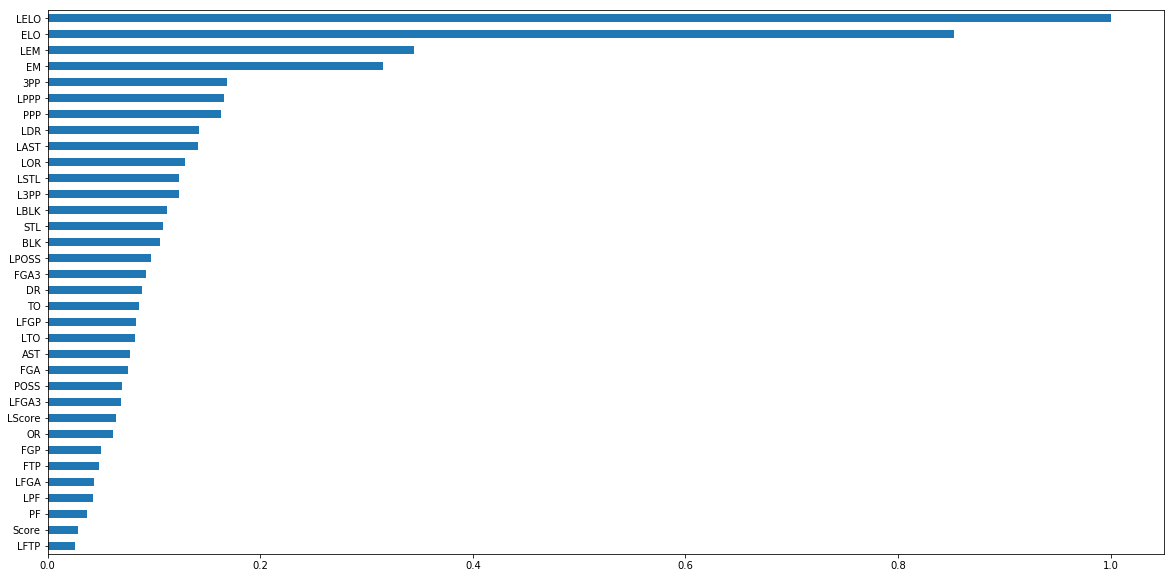

In [54]:
# Show feature importance
model = GradientBoostingClassifier(n_estimators=250,max_depth=2)
model.fit(Xs, y)

def showFeatureImportance(my_categories):
    fx_imp = pd.Series(model.feature_importances_, index=my_categories)
    fx_imp /= fx_imp.max()
    fx_imp = fx_imp.sort_values()
    plt.figure(figsize=(20,10))
    fx_imp.plot(kind='barh')
    plt.savefig('Feature_Importances.png')
    
    
showFeatureImportance(df_X.columns)


In [19]:
# Now predict tournament matchups.
print("Getting teams.")
df_teams_seeds = df_teams[['TeamID', 'TeamName']].rename(columns={'TeamName':'Team'})
seeds = pd.read_csv(folder + '/NCAATourneySeeds.csv')
seeds = pd.merge(left=seeds, right=df_teams_seeds, how='left', on='TeamID')
# for i in range(2017, 2018):
tourney_teams = []
for index, row in seeds.iterrows():
    if row['Season'] == prediction_year:
        tourney_teams.append(row['TeamID'])

Getting teams.


In [20]:
# Build our prediction of every matchup.
submission_data = []
print("Predicting matchups.")
tourney_teams.sort()
for team_a in tourney_teams:
    for team_b in tourney_teams:
        if team_a < team_b:
            prediction = predict_winner(
                team_a, team_b, model, prediction_year, stat_fields)
            label = str(prediction_year) + '_' + str(team_a) + '_' + \
                str(team_b)
            submission_data.append([label, prediction[0][0]])

Predicting matchups.


In [21]:
submission_data[:5]

[['2018_1104_1112', 0.20642049591127776],
 ['2018_1104_1113', 0.47675771835847713],
 ['2018_1104_1116', 0.32932828426657068],
 ['2018_1104_1120', 0.389799524825161],
 ['2018_1104_1137', 0.57460372462967957]]

In [22]:
# Write the results.
print("Writing %d results." % len(submission_data))
with open(folder + '/submission.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['ID', 'Pred'])
    writer.writerows(submission_data)


Writing 2278 results.


In [23]:
# Now so that we can use this to fill out a bracket, create a readable
# version.
print("Outputting readable results.")
team_id_map = build_team_dict()
readable = []
less_readable = []  # A version that's easy to look up.
for pred in submission_data:
    parts = pred[0].split('_')
    less_readable.append(
        [team_id_map[int(parts[1])], team_id_map[int(parts[2])], pred[1]])
    # Order them properly.
    if pred[1] > 0.5:
        winning = int(parts[1])
        losing = int(parts[2])
        proba = pred[1]
    else:
        winning = int(parts[2])
        losing = int(parts[1])
        proba = 1 - pred[1]
    readable.append(
        [
            '%s beats %s: %f' %
            (team_id_map[winning], team_id_map[losing], proba)
        ]
    )
with open(folder + '/readable-predictions.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerows(readable)
with open(folder + '/less-readable-predictions1.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerows(less_readable)

Outputting readable results.


In [24]:
pd.read_csv('DataFiles2018/Stage2UpdatedDataFiles/submission.csv').head()

,ID,Pred
0,2018_1104_1112,0.206420
1,2018_1104_1113,0.476758
2,2018_1104_1116,0.329328
3,2018_1104_1120,0.389800
4,2018_1104_1137,0.574604


In [25]:
df_predictions = pd.read_csv('DataFiles2018/Stage2UpdatedDataFiles/less-readable-predictions.csv',header=None)

In [26]:
pd.set_option('display.max_rows', 3000)

In [28]:
df_predictions

,0,1,2
0,Alabama,Arizona,0.228469
1,Alabama,Arizona St,0.454845
2,Alabama,Arkansas,0.401635
3,Alabama,Auburn,0.404177
4,Alabama,Bucknell,0.743973
5,Alabama,Buffalo,0.693540
6,Alabama,Butler,0.425980
7,Alabama,Cincinnati,0.196605
8,Alabama,Clemson,0.332579
9,Alabama,Col Charleston,0.704114
